# Nodal Analysis (Poettmann and Carpentar's Method)

## Introduction

* Empirical TPR Models developed for the multi-phase flow in vertical wells can be classified into homogeneous flow and separated flow models.
* Poettmann and Carpentar (1952) [homogeneous flow model] assumed no slip of liquid phases (b/w oil and water) in developing a gas–oil–water three-phase model that uses an estimate of the average mixture density and two-phase friction factor in computing the pressure losses in vertical wellbores.
* It uses friction factor but does not take liquid viscosity into account.
* Iterations are required to solve the Poettmann - Carpentar Model.
* The point of intersection of the IPR and TPR curves gives the operating point of the various tubing sizes. The tubing size with the maximum flow rate becomes the optimum tubing size.

**NOTE : Analysis is done considering the Bottom Hole as Node**

 IPR : Q<sub>o</sub> = J * (P<sub>res</sub> - P<sub> wf</sub>)

TPR : <ins>Poettmann-Carpenter Model</ins>

P<sub>wf</sub> = P<sub>wh</sub> + (Rho_mix + (k/Rho_mix)) * H / 144

k = f * M<sup>2</sup> * q<sup>2</sup> / 7.4137 * 10<sup>10</sup> * D<sup>5</sup>

* Here , f is the friction factor
* M is the mass flow rate

f = 10<sup>1.444 - 2.5 * log(D<sub>pv</sub>)</sup> <br>
where , D<sub>pv</sub> = 1.4737 * 10<sup>-5</sup> * M * q<sub>o</sub> / D

* D is inner diameter of tubing

M = 350.17 * (Y<sub>o</sub> + WOR * Y<sub>w</sub> + GOR * Rho_air * Y<sub>g</sub>) <br>

GLR = gas/liq = gas/(water + oil) = 1/(WGR + OGR) = GOR/(WOR + 1) = GOR*(1 - watercut) implies     ==>>     GOR = GLR / (1 - watercut) <br>

WOR = watercut / (1 - watercut) <br>

Y<sub>o</sub> = 141.5 / (<sup>o</sup>API + 131.5)

#### WellHead Parameters

* Vm_head = (5.615 * (Bo_head + WOR * Bw)) + ((GOR - Rs_head) * (14.7/P_head) * (T_head + 460 / 520) * (z/1.0))

* Rho_head = M / Vm_head
* Bo_head = 0.9759 + 0.00012(Rs_head * (Y<sub>g</sub>/Y<sub>o</sub>)<sup>0.5</sup> + 1.25 * T_head)<sup>1.2</sup> <br>
* Rs_head = Y<sub>g</sub> * ((P_head/18) * 10<sup>(0.0125 * API) - (0.00091 * T_head)</sup>)<sup>1.2048</sup>

### Parameter Calculations for z-factor calculation using the Beggs and Brill correlation

z = A + (1 - A)/e<sup>B</sup> + C * P<sub>pr</sub><sup>D</sup>

* A = 1.39 * (T<sub>pr</sub> - 0.92)<sup>0.5</sup> - 0.36 * T<sub>pr<sub> - 0.101
* B = (0.62 - 0.23) * P<sub>pr</sub> + [(0.066 / (T<sub>pr</sub> - 0.86)) - 0.037] * P<sub>pr</sub><sup>2</sup> + 0.32 * P<sub>pr</sub><sup>6</sup> / 10<sup>9 * (T<sub>pr</sub> - 1)</sup>
* C = 0.132 - 0.32 * log(T<sub>pr</sub>)
* D = 10<sup>(0.3016 - 0.49 * T<sub>pr</sub> + 0.1824 * T<sub>pr</sub><sup>2</sup>)</sup>

* P<sub>pr</sub> = P / P<sub>C</sub>
* T<sub>pr</sub> = T / T<sub>C</sub>

Since the values of P<sub>C</sub> and T<sub>C</sub> are not given , the z-factor cannot be calculated here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Well Parameters.xlsx')

val = df.set_index('Parameters')['Values'].to_dict()

# Extracting the parameters
Pres = val['Reservoir_Pressure']
Pb = val['Bubble_Point_Pressure']
J = val['Productivity_Index']
Pwh = val['WellHead_Pressure']
Twh = val['WellHead_Temperature']
Tbh = val['BottomHole_Temperature']
dTS = val['Depth_at_Tubing_Shoe']
Yw = val['Specific_Gravity_of_water']
Yg = val['Specific_Gravity_of_gas']
Rho_air = val['Density_of_air']
Bw = val['Water_Formation_Volume_Factor']
API = val['API_Gravity']
WC = val['WaterCut']
GLR = val['Gas_Liquid_Ratio']
D = 1.610 / 12 # Will change it later to excel

# Some derived parameters here
WOR = WC/(1 - WC)
GOR = GLR/(1 - WC)
Yo = 141.5/(131.5 + API)
M = (350.17 * (Yo + WOR * Yw)) + (GOR * Rho_air * Yg)

# Well Head Parameters
Rs_head = Yg * pow(((Pwh/18) * pow(10 , (0.0125*API - 0.00091*Twh))) , 1.2048)
Bo_head = 0.9759 + 0.00012 * pow((Rs_head * pow(Yg/Yo , 0.5) + 1.25*Twh) , 1.2)
Vm_head = (5.615 * (Bo_head + WOR * Bw)) + ((GOR - Rs_head) * (14.7/Pwh) * ((Twh + 460)/520))
Rho_head = M / Vm_head

In [3]:
def nodal_analysis(df):
    val = df.set_index('Parameters')['Values'].to_dict()

    # Extracting the parameters
    Pres = val['Reservoir_Pressure']
    Pb = val['Bubble_Point_Pressure']
    J = val['Productivity_Index']
    Pwh = val['WellHead_Pressure']
    Twh = val['WellHead_Temperature']
    Tbh = val['BottomHole_Temperature']
    dTS = val['Depth_at_Tubing_Shoe']
    Yw = val['Specific_Gravity_of_water']
    Yg = val['Specific_Gravity_of_gas']
    Rho_air = val['Density_of_air']
    Bw = val['Water_Formation_Volume_Factor']
    API = val['API_Gravity']
    WC = val['WaterCut']
    GLR = val['Gas_Liquid_Ratio']
    D = 1.610 / 12 # Will change it later to excel

    IPR_dataPoints = []
    TPR_dataPoints = []
    Q = []
    AOF = J * Pres
    Qo = 10

    while Qo < AOF:

        # Pwf from IPR Calculations
        Pwf_IPR = Pres - (Qo/J)
        IPR_dataPoints.append(Pwf_IPR)

        # Bottom Hole Parameters
        Rs_bottom = Yg * pow(((Pwf_IPR/18) * pow(10 , (0.0125*API - 0.00091*Tbh))) , 1.2048)
        Bo_bottom = 0.9759 + 0.00012 * pow((Rs_bottom * pow(Yg/Yo , 0.5) + 1.25*Tbh) , 1.2)
        Vm_bottom = (5.615 * (Bo_bottom + WOR * Bw)) + ((GOR - Rs_bottom) * (14.7/Pwf_IPR) * ((Tbh + 460)/520))
        Rho_bottom = M / Vm_bottom

        # Average Rho Calculation
        Rho_mix = 0.5 * (Rho_head + Rho_bottom)

        # TPR Calculations
        Dpv = (1.4737 * (10**-5) * M * Qo) / D
        f = pow(10 , 1.444 - 2.5 * np.log10(Dpv))
        K = f * M**2 * Qo**2 / (7.4137 * 10**10 * D**5)

        Pwf_TPR = Pwh + ((Rho_mix + (K / Rho_mix)) * (dTS / 144))
        TPR_dataPoints.append(Pwf_TPR)

        Q.append(Qo)
        Qo += 10

    return IPR_dataPoints , TPR_dataPoints , Q

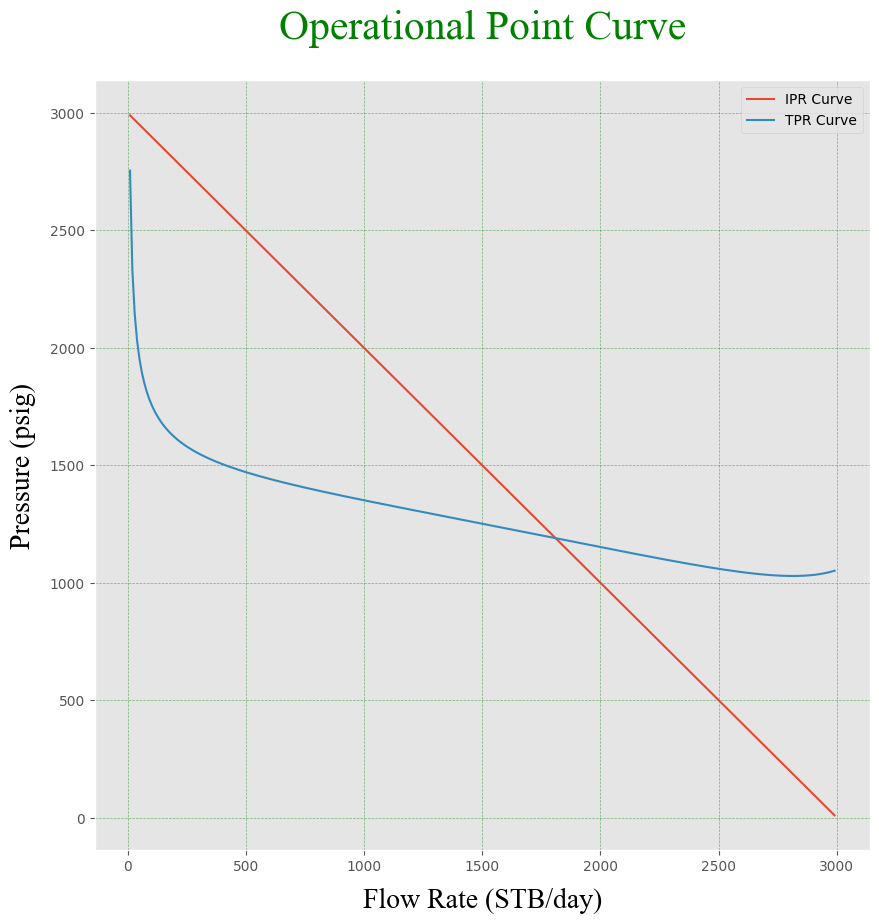

In [4]:
IPR , TPR , Q = nodal_analysis(df)

plt.style.use('ggplot')
plt.figure(figsize = (10 , 10))
font_Title = {'color' : 'g' , 'size' : 30 , 'family' : 'Times New Roman'}
plt.plot(Q , IPR , label = 'IPR Curve')
plt.plot(Q , TPR , label = 'TPR Curve')
plt.grid(True , color = 'g' , ls = '--' , lw = 0.5 , alpha = 0.5)
plt.xlabel('Flow Rate (STB/day)' , c = 'k' , labelpad = 10 , fontsize = 20 , font = 'Times New Roman')
plt.ylabel('Pressure (psig)' , c = 'k' , labelpad = 10 , fontsize = 20 , font = 'Times New Roman')
plt.title('Operational Point Curve' , fontdict = font_Title , pad = 30)
plt.legend()
plt.show()